# Matched Filtering Tutorial

This tutorial introduces matched filter in the context of detecting gravitational waves with LIGO. 

It borrows from a problem set developed by Christopher Berry.

Author: Maya Fishbach

## Solutions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

Before we begin - download the [LIGO data](https://northwestern.box.com/s/qpd1m5gkdwtqtflesx7bf19oz6fbixl7) necessary for this notebook. This download may take a bit of time.

## Problem 1) Detector Noise Curves

Read in the Hanford (H1) and Livingston (L1) amplitude spectral densities (ASD) data files (`H1-ASD.txt`, `L1-ASD.txt`).

In [2]:
# Load the ASD data
dir = './Matched_Filter_Data/' #point to your local directory containing the data files

H1 = pd.read_csv(dir+'H1-ASD.txt', delim_whitespace=True)
L1 = pd.read_csv(dir+'L1-ASD.txt', delim_whitespace=True)

In [3]:
H1

,frequency(Hz),ASD(Hz^-0.5)
0,0.125,3.557570e-19
1,0.250,3.748115e-19
2,0.375,2.638521e-19
3,0.500,1.268282e-19
4,0.625,4.338996e-20
...,...,...
65531,8191.500,4.168264e-28
65532,8191.625,6.825673e-28
65533,8191.750,7.570527e-28
65534,8191.875,6.983422e-28


#### Problem 1a
From the ASDs, calculate the power spectral densities (PSDs) $S_n(f)$.

##### The PSD is just the square of the ASD. 

In [4]:
H1['PSD'] = H1['ASD(Hz^-0.5)']**2
L1['PSD'] = L1['ASD(Hz^-0.5)']**2

#### Problem 1b
Plot the PSDs for Hanford and Livingston. 

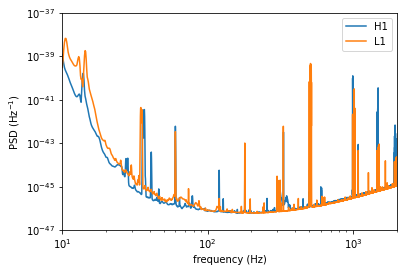

In [5]:
plt.loglog(H1['frequency(Hz)'], H1['PSD'], label = 'H1')
plt.loglog(L1['frequency(Hz)'], L1['PSD'], label = 'L1')
plt.legend(loc = 'best')

plt.ylabel('PSD (Hz$^{-1}$)')
plt.xlabel('frequency (Hz)')

plt.xlim(10, 2000)
plt.ylim(10**-47,10**-37)

plt.show()

#### Problem 1c

(no code) Looking at your plot of the PSDs, at approximately what frequencies are the detectors most sensitive?

##### The detectors are most sensitive in the bucket around 100 Hz

#### Problem 1d
These ASDs have been calculated from data sampled in the time domain. What is the maximum frequency of the ASDs? What does this imply for the minimum sampling rate for the time domain data? Explain why.

*Hint*: You can find the actual sampling rate in the [GWOSC Open Data paper](https://arxiv.org/abs/1912.11716). 

In [6]:
max_frequency = np.amax(H1['frequency(Hz)'])

min_sampling_rate = max_frequency*2

print('The minimum sampling rate is %.f'%(min_sampling_rate))

The minimum sampling rate is 16384


The max frequency is 8192 Hz. The sampling rate must be at least twice this, so that we avoid aliasing. The maximum frequency in the  data must be less than or equal to the Nyquist frequency, whist is half the sampling rate. The data must therefore be sampled at 16384 Hz or higher. In fact, they are sampled at 16384 Hz.

## Problem 2) datastreams and template waveforms

You have been given three noisy datastreams $h(t)$, each 600 seconds long, for the Hanford and Livingston detectors: `*1-a.txt`, `*1-b.txt` and `*1-c.txt`, where `*` is `H` for Hanford and `L` for Livingston.

These data streams all contain Gaussian noise drawn from the PSDs in Problem 1. They may additionally contain signals from compact binary inspirals.  

In [7]:
# load the data
H1a = pd.read_csv(dir+'H1-a.txt', delim_whitespace=True)
H1b = pd.read_csv(dir+'H1-b.txt', delim_whitespace=True)
H1c = pd.read_csv(dir+'H1-c.txt', delim_whitespace=True)
L1a = pd.read_csv(dir+'L1-a.txt', delim_whitespace=True)
L1b = pd.read_csv(dir+'L1-b.txt', delim_whitespace=True)
L1c = pd.read_csv(dir+'L1-c.txt', delim_whitespace=True)

You have also been given template waveforms $T(t)$ for a binary black hole, neutron star black hole, and binary neutron star coalescence: `bbh-waveform.txt`, `nsbh-waveform.txt` and `bns-waveform.txt`.

In [8]:
#load the waveform templates
bbh = pd.read_csv(dir+'bbh_waveform.txt', delim_whitespace=True)
nsbh = pd.read_csv(dir+'nsbh_waveform.txt', delim_whitespace=True)
bns = pd.read_csv(dir+'bns_waveform.txt', delim_whitespace=True)

In [9]:
bbh

,time(s),strain
0,-8.468506,0.000000e+00
1,-8.468262,3.211971e-28
2,-8.468018,1.289550e-27
3,-8.467773,2.909717e-27
4,-8.467529,5.183063e-27
...,...,...
34805,0.028809,-1.063762e-26
34806,0.029053,-6.165901e-27
34807,0.029297,-4.918303e-27
34808,0.029541,-2.481310e-27


#### Problem 2a
Plot the template waveforms $T(t)$. Try zooming into the last one or two seconds before merger (time = 0).

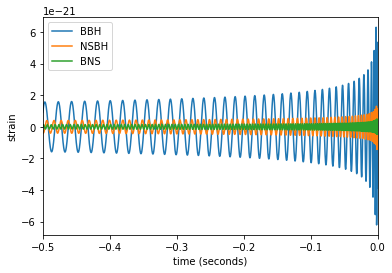

In [10]:
templates = [bbh, nsbh, bns]
labels = ['BBH', 'NSBH', 'BNS']

for i, T in enumerate(templates):
    plt.plot(T['time(s)'], T['strain'], label = labels[i])

plt.legend(loc = 'best')
    
plt.xlabel('time (seconds)')
plt.ylabel('strain')

plt.xlim(-0.5, 0) #zoom into the last half second before merger
plt.show()

#### Problem 2b
Plot the datastreams $h(t)$. By eye, can you identify the presence of signals?

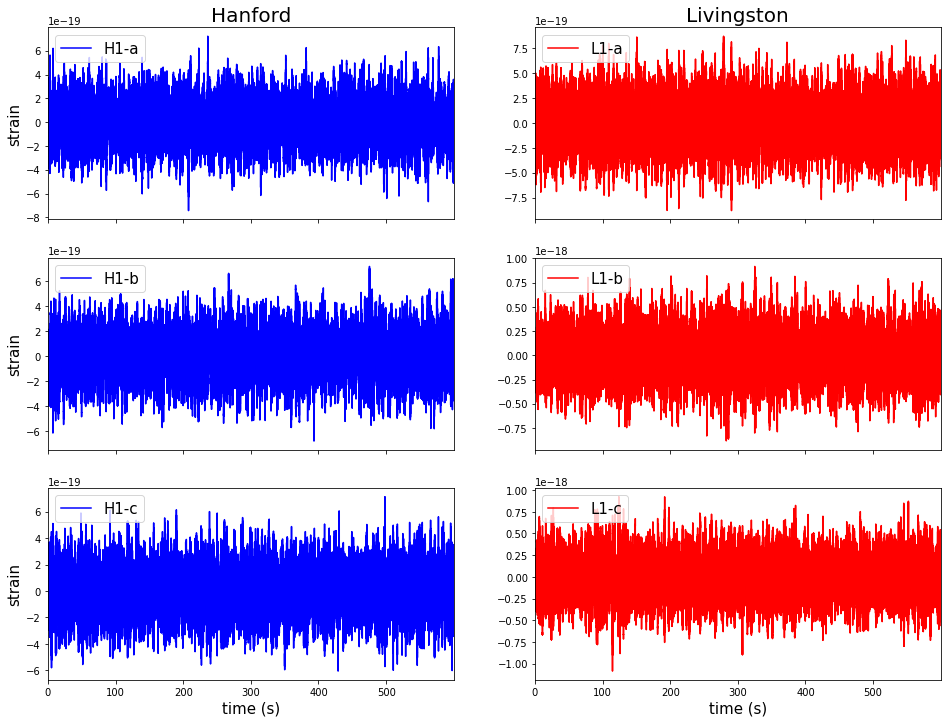

In [11]:
H1_data = [H1a,H1b,H1c]
L1_data = [L1a,L1b,L1c]
labels = ['a','b','c']

# plot the strain data
f, axs = plt.subplots(nrows=3, ncols=2, sharex=True, figsize=(16,12))

# label plots
axs[0,0].set_title('Hanford', fontsize=20)
axs[0,1].set_title('Livingston', fontsize=20)

axs[2,0].set_xlabel('time (s)', fontsize=15)
axs[2,1].set_xlabel('time (s)', fontsize=15)

axs[0,0].set_ylabel('strain', fontsize=15)
axs[1,0].set_ylabel('strain', fontsize=15)
axs[2,0].set_ylabel('strain', fontsize=15)

idx=0
for H1_tmp, L1_tmp, lbl in zip(H1_data, L1_data, labels):
    axs[idx,0].plot(H1_tmp['time(s)'], H1_tmp['strain'], color='b', label='H1-'+lbl)
    axs[idx,1].plot(L1_tmp['time(s)'], L1_tmp['strain'], color='r', label='L1-'+lbl)
    axs[idx,0].legend(loc='upper left', prop={'size':15})
    axs[idx,1].legend(loc='upper left', prop={'size':15})
    axs[idx,0].set_xlim(0,H1_tmp['time(s)'].max())
    axs[idx,1].set_xlim(0,L1_tmp['time(s)'].max())
    idx+=1

##### No! Note that the noise strain amplitude ($\mathcal{O}(10^{-19})$) is much larger than the signal amplitude ($\mathcal{O}(10^{-21})$). You definitely cannot see any signals by eye.

## Problem 3) Matched filter signal-to-noise ratio (SNR) time series

Using template waveforms $T(t)$, we will calculate and plot the matched filter SNR  as a function of the time shift $\tau$ between the template $T(t)$ and the data $h(t)$. We will repeat this for each of the three templates in each of the three datastreams, looking for peaks in the SNR time series that indicate the presence of gravitational-wave signals.

#### NOTE 1: 
We will first need to Fourier transform both the template $T(t)$ and the data $h(t)$. Do not worry about normalizing your Fourier transforms, as we are only interested in qualitative results here.

##### NOTE 2: 
To do the SNR calculation as a function of the time shift $\tau$, we will need the template to be the same length of the time as the data. There are two ways to achieve this: 

OPTION A: Artificially increase the length of the template waveform by zero-padding the template, such that the template is the same length of time as the data.

OPTION B: Look at a small chunk of data at a time, taking chunks of the data with time durations equal to the template. Perform the SNR calculation by "sliding" the template across the shortened data. 

##### Here, we go with the method in which we zero-pad the template

#### Problem 3a
Zero-pad the BBH, NSBH, and BNS templates so that the templates are the same length as the H1-(a,b,c) & L1-(a,b,c) datastreams. The data from H1-(a,b,c) & L1-(a,b,c) are the same size, so the padding on each template is the same regardless of the datastream.

In [12]:
#Here we pad the template by placing zeros at the end

def pad_template(template):
    pad_width = H1a['strain'].size - template['strain'].size
    padded_template = np.pad(template['strain'],  ((0, pad_width),)) #place all the zeros at the end
    return padded_template
    
padded_bbh = pad_template(bbh)
padded_bns = pad_template(bns)
padded_nsbh = pad_template(nsbh)

#### Problem 3b

Compute the Fourier transform the templates and plot the Fourier-transformed templates $\tilde{T}(f)$ as a function of frequency. Since the templates are all real, you only need to plot the positive Fourier frequencies and the magnitude of the Fourier transform.

Note that the sampling rate is the same for all the templates (and all the timestreams), so the sampled frequencies are the same. (In other words, since the time bins are the same, the frequency bins are the same.)

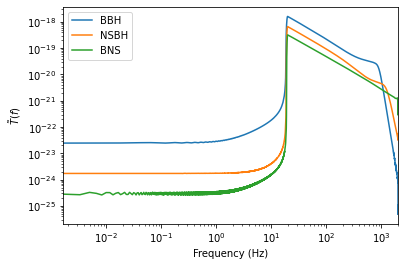

In [14]:
#first compute the corresponding frequency bins for the Fourier transform

sample_spacing = (H1a['time(s)'][1]-H1a['time(s)'][0]) #in seconds
window_length = len(H1a['time(s)'])
freq = np.fft.fftfreq(window_length, d=sample_spacing)

#now take the Fourier transforms of the templates

Tf_bbh = np.fft.fft(padded_bbh)
Tf_nsbh = np.fft.fft(padded_nsbh)
Tf_bns = np.fft.fft(padded_bns)

#select the positive frequencies and plot in log-log space

sel = freq > 0

labels = ['BBH', 'NSBH', 'BNS']
for i, Tf in enumerate([Tf_bbh, Tf_nsbh, Tf_bns]):
    plt.loglog(freq[sel], np.abs(Tf[sel]), label = labels[i])

plt.legend(loc = 'best')
plt.xlim(min(freq[sel]), max(freq[sel]))
plt.ylabel(r'$\tilde{T}(f)$')
plt.xlabel('Frequency (Hz)')
plt.show()

#### Problem 3c

Compute the matched filter signal-to-noise ratio timeseries between the templates and the datastreams. Start by computing the matched filter SNR timeseries between the BBH template and the "(a) datastream" in the Hanford detector (H1-a).

##### Note: we need to interpolate the PSDs so that we can evaluate them at the same frequencies as the templates and datastreams.

Recall that one can calculate the matched filter signal-to-noise ratio timeseries by taking the inverse Fourier transform of 
$$
\frac{\tilde{T}^*(f) \tilde{h}(f)}{S_n(f)}
$$

where $\tilde{T}^*(f)$ is the complex conjugate of the template in the frequency domain, $\tilde{h}(f)$ is the datastream in the frequency domain, and $S_n(f)$ is the PSD.

In [15]:
def matched_filter_snr(template_Tf, freq_sampled, data_ht, psd):
    """ Compute the matched filter SNR time series
    template_Tf: waveform template in the frequency domain (Tf_bbh, Tf_nsbh, or Tf_bns from Problem 2)
    freq_sampled: frequency bins corresponding to template_Tf, (freq from Problem 2)
    data_ht: the datastream in the time domain, e.g. H1-a, L1-b
    psd: the PSD data from problem 1, either H1 or L1.
    """
    
    #evaluate the PSD at the frequencies: 
    #because we are working only with real timeseries, the negative frequencies are the same as the positive frequencies
    psd_interp = np.interp(np.abs(freq_sampled), psd['frequency(Hz)'], psd['PSD'])
    
    #Fourier transform the data to the frequency domain
    data_hf = np.fft.fft(data_ht['strain'])
    
    #compute matched filter SNR in the frequency domain
    snr_freq = template_Tf.conjugate() * data_hf / psd_interp
    
    #inverse Fourier transform the SNR to the time domain
    snr_time = np.fft.ifft(snr_freq)
    
    return data_ht['time(s)'], np.abs(snr_time)

time, snr_time = matched_filter_snr(Tf_bbh, freq, H1a, H1)

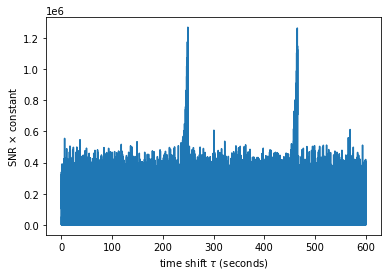

In [16]:
#plot the timeseries
plt.plot(time, snr_time)
plt.xlabel(r'time shift $\tau$ (seconds)')
plt.ylabel(r'SNR $\times$ constant')
plt.show()

#### Problem 3d
Plot the SNR timeseries for each template in each of the (a), (b) and (c) datastreams, in each detector (18 combinations total). Do you see spikes in the SNR value as a function of the time shift? Which waveform signals are embedded within which datastreams? 

##### Note: each datastream may contain multiple signals.

In [17]:
template_Tfs = {"BBH" : Tf_bbh, "NSBH" : Tf_nsbh, "BNS" : Tf_bns}

datastreams = {"a": (H1a, L1a), "b": (H1b, L1b), "c": (H1c, L1c)}

def plot_snr_timeseries(datastream):   
    """
    plot the SNR timeseries for each of the three templates in the given datastream
    datastream is 'a', 'b' or 'c' 
    """
    
    #set up two subplots, one for H1 and one for L1 
    fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, figsize = (12, 4))
    plt.suptitle('Datastream '+datastream)

    axs[0].set_title('H1 (Hanford)')
    axs[1].set_title('L1 (Livingston)')
    for ax in axs:
        ax.set_xlabel(r'time shift $\tau$ (seconds)')
        ax.set_ylabel(r'SNR $\times$ constant')
    
    
    #loop over the templates
    for wf in template_Tfs.keys():
    
        template_Tf = template_Tfs[wf]
        
        time, snr_H1 = matched_filter_snr(template_Tf, freq, datastreams[datastream][0], H1)
        
        time, snr_L1 = matched_filter_snr(template_Tf, freq, datastreams[datastream][1], L1)

        #overplot the SNR timeseries for each template in the same detector (H1 or L1)
        axs[0].plot(time, snr_H1, label = wf, alpha = 0.5)
        axs[1].plot(time, snr_L1, label = wf, alpha = 0.5)
        
    axs[0].legend(loc = 'best')

    plt.show()

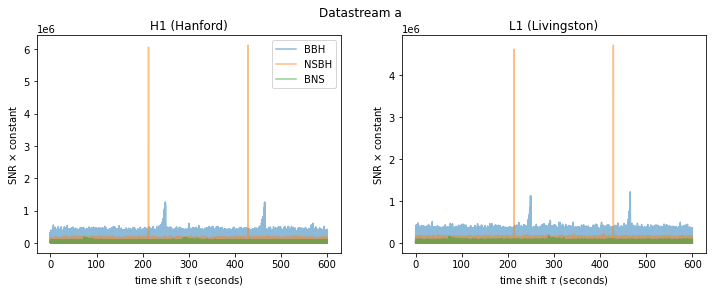

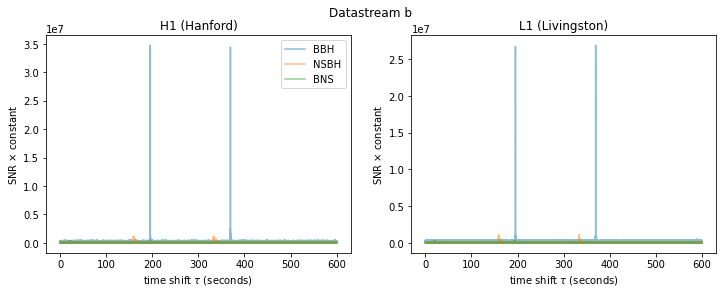

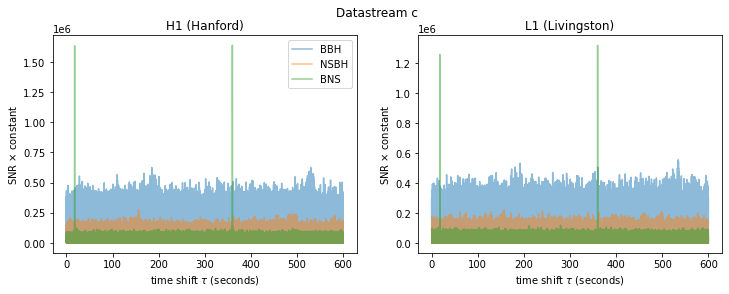

In [18]:
plot_snr_timeseries("a")

plot_snr_timeseries("b")

plot_snr_timeseries("c")

##### We see that "datastream a" has two NSBH signals, "datastream b" has two BBH signals, and "datastream c" has two BNS signals.

#### Problem 3e
Using the results from part (d), overplot the signal time-domain waveforms over the datastreams that contain them. You can do this just for H1 datastreams, and just for one signal in each datastream. Your results should illustrate the power of matched filtering.  

##### Note: think about how the zero time $\tau = 0$ is defined. 

In [19]:
# first we need to calculate the time at which the SNR timeseries peaks. We pick the loudest peak.

def calculate_tau_maxSNR(datastream, template):
    ds = datastreams[datastream]
    tmp = template_Tfs[template]
    
    time, snr_H1 = matched_filter_snr(tmp, freq, ds[0], H1)
    
    tau = time[np.argmax(snr_H1)]
    
    return tau

In [20]:
tau_a = calculate_tau_maxSNR("a", "NSBH") #time at which the correct template peaks in the H1a datastream

tau_b = calculate_tau_maxSNR("b", "BBH") #time at which the correct template peaks in the H1b datastream

tau_c = calculate_tau_maxSNR("c", "BNS") #time at which the correct template peaks in the H1c datastream

In [28]:
print(tau_a, tau_b, tau_c)

428.735839844 195.500732422 359.860107422


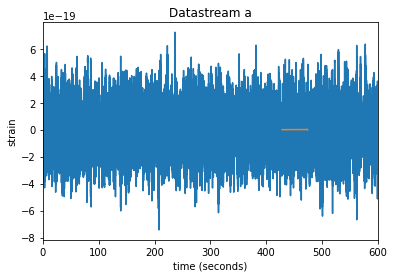

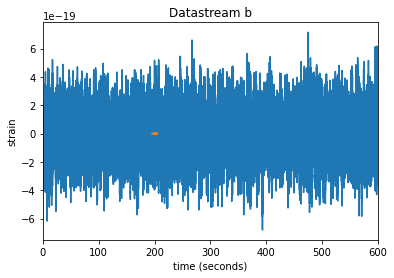

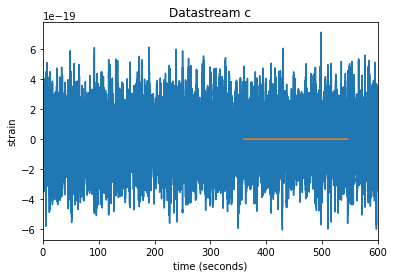

In [33]:
times = H1a['time(s)']

plt.plot(times, H1a['strain'])
sel = np.abs(padded_nsbh) >  0 #select only the part that we didn't zero pad
plt.plot(times[sel]+tau_a, padded_nsbh[sel])
plt.xlabel("time (seconds)")
plt.ylabel("strain")
plt.title("Datastream a")
plt.xlim(0, 600)
plt.show()

plt.plot(times, H1b['strain'])
sel = np.abs(padded_bbh) >  0 #select only the part that we didn't zero pad
plt.plot(times[sel]+tau_b, padded_bbh[sel])
plt.xlabel("time (seconds)")
plt.ylabel("strain")
plt.title("Datastream b")
plt.xlim(0, 600)
plt.show()

plt.plot(times, H1c['strain'])
sel = np.abs(padded_bns) >  0 #select only the part that we didn't zero pad
plt.plot(times[sel]+tau_c, padded_bns[sel])
plt.xlabel("time (seconds)")
plt.ylabel("strain")
plt.title("Datastream c")
plt.xlim(0, 600)
plt.show()

##### Even with the knowledge of the correct locations of the signals, they are impossible to see by eye.  Thank you matched filtering!

### Problem 4 (challenge): visualize data

Experiment with whitening and bandpassing the data. This can make signals easier to see (for visualization purposes, as our eyes are not as good as matched filtering). As an example, have a look at Figure 3 of the [LIGO & Virgo Data Analysis Guide](https://arxiv.org/abs/1908.11170).

#### Problem 4a 
Remake the plots from Problem 3e using whitened data.

(0.0, 600.0)

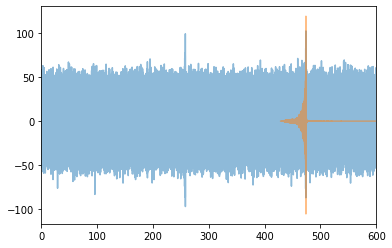

In [64]:
data_whitened_hf = np.fft.fft(H1a['strain'])/np.interp(np.abs(freq), H1['frequency(Hz)'], H1['ASD(Hz^-0.5)'])
data_whitened = np.fft.ifft(data_whitened_hf)

template_whitened_Tf = np.fft.fft(padded_nsbh)/np.interp(np.abs(freq), H1['frequency(Hz)'], H1['ASD(Hz^-0.5)'])
template_whitened = np.fft.ifft(template_whitened_Tf)

plt.plot(times, np.absolute(data_whitened)*np.real(np.sign(data_whitened)), alpha = 0.5)
plt.plot(times + tau_a, np.absolute(template_whitened) * np.real(np.sign(template_whitened)), alpha = 0.5)
plt.xlim(0, 600)

#### Problem 4b
Experiment with bandpassing the whitened data (e.g. using a Butterworth filter) to remove the noisiest frequencies, and remake some plots from Problem 3e.

/opt/anaconda3/envs/populations/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(0.0, 600.0)

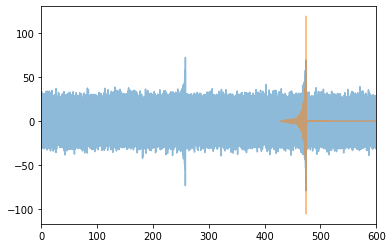

In [68]:
#see https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

lowcut = 30
highcut = 600
fs = 1./sample_spacing

data_bandpassed = butter_bandpass_filter(data_whitened, lowcut, highcut, fs, order = 8)
plt.plot(times, data_bandpassed, alpha = 0.5)
plt.plot(times + tau_a, np.absolute(template_whitened) * np.real(np.sign(template_whitened)), alpha = 0.5)
plt.xlim(0, 600)

#### Problem 4c
Experiment with making time-frequency spectograms to visualize the data. Check out the [Q-transform](https://gwpy.github.io/docs/stable/examples/timeseries/qscan.html) from `gwpy`. 

In [93]:
from gwpy.timeseries import TimeSeries

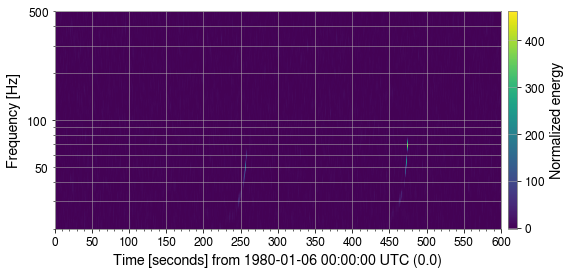

In [105]:
data = TimeSeries(H1a['strain'], sample_rate=fs)
qspecgram = data.q_transform()
plot = qspecgram.plot(figsize=[8, 4])
ax = plot.gca()
ax.set_xscale('seconds')
ax.set_yscale('log')
ax.set_ylim(20, 500)
ax.set_ylabel('Frequency [Hz]')
ax.grid(True, axis='y', which='both')
ax.colorbar(cmap='viridis', label='Normalized energy')
plot.show()

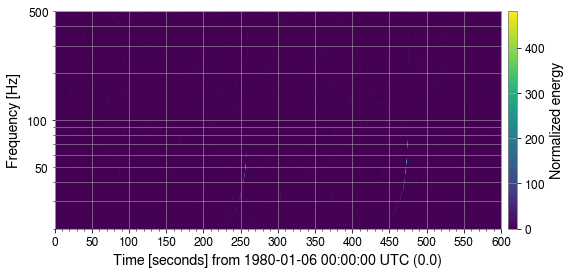

In [106]:
data = TimeSeries(L1a['strain'], sample_rate=fs)
qspecgram = data.q_transform()
plot = qspecgram.plot(figsize=[8, 4])
ax = plot.gca()
ax.set_xscale('seconds')
ax.set_yscale('log')
ax.set_ylim(20, 500)
ax.set_ylabel('Frequency [Hz]')
ax.grid(True, axis='y', which='both')
ax.colorbar(cmap='viridis', label='Normalized energy')
plot.show()

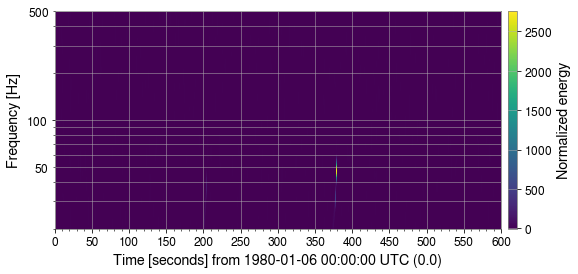

In [101]:
data = TimeSeries(H1b['strain'], sample_rate=fs)
qspecgram = data.q_transform()
plot = qspecgram.plot(figsize=[8, 4])
ax = plot.gca()
ax.set_xscale('seconds')
ax.set_yscale('log')
ax.set_ylim(20, 500)
ax.set_ylabel('Frequency [Hz]')
ax.grid(True, axis='y', which='both')
ax.colorbar(cmap='viridis', label='Normalized energy')
plot.show()

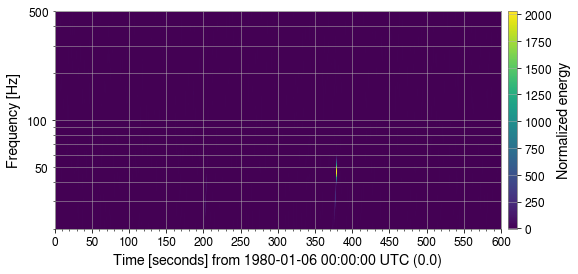

In [102]:
data = TimeSeries(L1b['strain'], sample_rate=fs)
qspecgram = data.q_transform()
plot = qspecgram.plot(figsize=[8, 4])
ax = plot.gca()
ax.set_xscale('seconds')
ax.set_yscale('log')
ax.set_ylim(20, 500)
ax.set_ylabel('Frequency [Hz]')
ax.grid(True, axis='y', which='both')
ax.colorbar(cmap='viridis', label='Normalized energy')
plot.show()

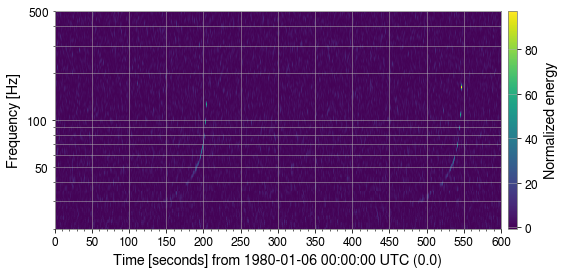

In [103]:
data = TimeSeries(H1c['strain'], sample_rate=fs)
qspecgram = data.q_transform()
plot = qspecgram.plot(figsize=[8, 4])
ax = plot.gca()
ax.set_xscale('seconds')
ax.set_yscale('log')
ax.set_ylim(20, 500)
ax.set_ylabel('Frequency [Hz]')
ax.grid(True, axis='y', which='both')
ax.colorbar(cmap='viridis', label='Normalized energy')
plot.show()

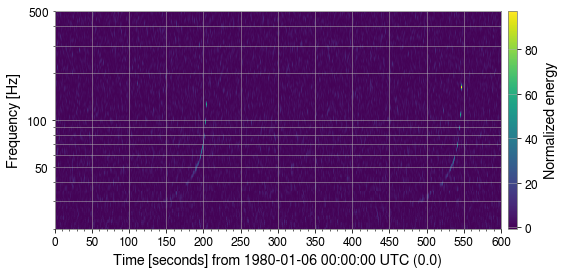

In [104]:
data = TimeSeries(H1c['strain'], sample_rate=fs)
qspecgram = data.q_transform()
plot = qspecgram.plot(figsize=[8, 4])
ax = plot.gca()
ax.set_xscale('seconds')
ax.set_yscale('log')
ax.set_ylim(20, 500)
ax.set_ylabel('Frequency [Hz]')
ax.grid(True, axis='y', which='both')
ax.colorbar(cmap='viridis', label='Normalized energy')
plot.show()